In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<center><b>CSIE604284 • Analitika Media Sosial</b></center>
<center><b>Fakultas Ilmu Komputer, Universitas Indonesia</b></center>
<center><b>Tutorial 1 - Text Mining</b></center>
<center><i>Deadline</i> Pengumpulan: Senin, 14 Maret 2022, pukul 22.00 WIB</center>

<b>Instruksi Pengerjaan</b>:
* Tugas ini adalah tugas individu. 
* Anda diberikan berkas Tutorial1_TextMining.ipynb dan kumpulan data pada folder dataset.
* Terdapat dua link notebook Colab lainnya sebagai Bonus dan Eksplorasi terkait Word Embedding + Language Model.
* Tuliskan jawaban Anda pada berkas ini dan kumpulkan melalui SCeLE dengan format penamaan Tutorial1_NPM_Nama.(ipynb/zip) sebelum Senin, 14 Maret 2022 pukul 22:00 WIB. 

# A. Klasifikasi Emosi pada Tweet Bahasa 

Pada tutorial ini, kita akan mengklasifikasikan <i>tweet</i> Bahasa Indonesia ke dalam lima kelas emosi yaitu senang, cinta, marah, sedih, dan takut. <i>Dataset</i> yang digunakan dalam percobaan ini didapatkan dari <i>paper</i> berikut:

Mei Silvana Saputri, Rahmad Mahendra, and Mirna Adriani, <i>Emotion Classification on Indonesian Twitter Dataset</i>.  International Conference on Asian Language Processing (IALP) 2018. Bandung. 2018. 

****
<br/>

<i>Dataset</i> terdiri dari 4.403 <i>tweet</i> yang sudah dilakukan <i>pre-processing</i> dengan ketentuan sebagai berikut:
* <i>Username</i> dan <i>mention</i> (ditandai dengan @) diganti dengan kata [USERNAME]
* URL/<i>hyperlink</i> (http:// atau https://..) diganti dengan kata [URL]
* Nomor sensitif, misalnya nomor telepon, nomor <i>invoice</i>, dan nomor pelacakan jasa pengiriman diganti dengan kata [SENSITIVE-NO]

<i>Dataset</i> ini memuat <i>tweet</i> beremosi eksplisit dan implisit. Berikut adalah contoh <i>tweet</i> beremosi eksplisit dan implisit.

<br/>

<b>Emosi Eksplisit</b>

hari ini libur, rencananya mau nonton Jurassic World, tapi kayanya gajadi deh mengingat kondisi yg gak fit bgt ini <b>sebel</b>. Rusak rencana sebelanga.. <b>sebel</b> akutu <font color='red'>(marah)</font>

<b>Emosi Implisit</b>

Ini aja membuktikan anda sudah TIDAK BENAR....!!! MASA NAPI KORUPTOR BISA PUNYA HP DI PENJARA ITU SDH MELANGGAR ATURAN.... DAN ANDA DG ENAKNYA MELANGGAR ATURAN...!! INI MENANDAKAN BAHWA ITULAH KARAKTER ANDA <font color='red'>(marah)</font>|

<br/>

Untuk mengklasifikasikan <i>tweet</i> menjadi lima kelas emosi, dilakukan ekstraksi 4 fitur berikut:
* Fitur Unigram
* Fitur Leksikon Sentimen 
* Fitur POS Tag
* Fitur Ortografi

<br/>

****

<br/>

Langkah-langkah untuk melakukan klasifikasi emosi pada <i>dataset tweet</i> emosi tersebut adalah sebagai berikut:

## <b>1. Import library</b><br>
<i>Library</i> yang digunakan pada tutorial ini antara lain pandas, numpy, nltk, Sastrawi, dan sklearn. 

<b>#Code 1</b>

In [82]:
!pip install nltk
!pip install Sastrawi
!pip install python-crfsuite

import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import Sastrawi
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from nltk.tag import CRFTagger
from collections import Counter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## <b>2. Membaca data</b><br>
Data dibaca dengan <i>library</i> pandas.

<b>#Code 2</b>

In [95]:
# membaca data
path = '/content/drive/MyDrive/Ilmu Komputer UI/Analitika Media Sosial/Tutorial/Tutorial 1/dataset/'
raw_data = pd.read_csv(path + "Twitter_Emotion_Dataset.csv",
                       delimiter=",", encoding="Latin-1")
print(raw_data.shape[0])
raw_data.head()

4401


,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


## <b>3. Pra-pemrosesan data</b><br>
Data Twitter bersifat <i>unstructured</i> dan memiliki format penulisan bebas (tidak sesuai kaidah penulisan yang benar). Oleh karena itu, dilakukan pra-pemrosesan data untuk melakukan normalisasi isi <i>tweet</i>. 

Dalam percobaan ini, dilakukan pra-pemrosesan berupa:

    a. Normalisasi tweet
    Normalisasi tweet terdiri dari pengubahan ke huruf kecil, pembuangan spasi yang berlebihan, trimming, pembuangan tanda baca, penghilangan huruf berulang (misalnya haiiii -> hai). Fungsi normalisasi (tweet) menerima input berupa satu buah tweet mentah bertipe string. 

<b>#Code 3a</b>

In [84]:
def normalisasi(tweet):
    normal_tw = tweet.lower()  # lowercase
    normal_tw = re.sub('\s+', ' ', normal_tw)  # remove extra space
    normal_tw = normal_tw.strip()  # trim space depan belakang
    normal_tw = re.sub(r'[^\w\s]', '', normal_tw)  # buang punctuation
    # regex huruf yang berulang kaya haiiii (untuk fitur unigram)
    normal_regex = re.compile(r"(.)\1{1,}")
    # buang huruf yang berulang
    normal_tw = normal_regex.sub(r"\1\1", normal_tw)
    return normal_tw

    b. Pembuangan stopwords dan istilah spesial (username, hyperlink, sensitive-no)
    Daftar stopwords didapatkan dari penelitian Tala.
    
    Tala, F. Z. (2003). A Study of Stemming Effects on Information Retrieval in Bahasa Indonesia. M.S. thesis. M.Sc. Thesis. Master of Logic Project. Institute for Logic, Language and Computation. Universiteti van Amsterdam The Netherlands.
    
    Fungsi remove_stopwords(tweet) menerima masukan berupa tweet yang sudah dinormalisasi yang bertipe string.
    
<b># Code 3b</b>

In [85]:
def remove_stopwords(tweet):
    token = nltk.word_tokenize(tweet)
    token_afterremoval = []
    for k in token:
        if k not in stopwords and k not in special_list: # tag tweet message
            token_afterremoval.append(k)

    str_clean = ' '.join(token_afterremoval)
    return str_clean

    c. Di luar tutorial ini Anda bisa mencoba opsi stemming pada tahap pra-pemrosesan. Fungsi stemming akan didefinisikan pada tutorial ini, namun tidak dijalankan untuk mempercepat proses normalisasi isi tweet. Pra-pemrosesan sifatnya tidak wajib seluruhnya diterapkan. Fungsi stemming(tweet) menerima masukan berupa satu buah tweet bertipe string. 

<b>#Code 3c</b>

In [86]:
def stemming(tweet):
    token = nltk.word_tokenize(tweet)
    stem_kalimat = []
    for k in token:
        stem_kata = stemmer.stem(k)
        stem_kalimat.append(stem_kata)

    stem_kalimat_str = ' '.join(stem_kalimat)
    return stem_kalimat_str

    d. Pra-pemrosesan tweet secara keseluruhan
    Pada tahap ini, akan dilakukan pemanggilan fungsi normalisasi dan remove_stopwords yang sudah didefinisikan sebelumnya. Setelah itu akan ditampilkan sampel tiga tweet pertama yang sudah dilakukan pra-pemrosesan. 
    
<b>#Code 3d</b>    

In [87]:
def pra_pemrosesan(list_tweet):
    tweet_clean = []
    for tw in list_tweet:
        normal_tweet = normalisasi(tw)
        # normal_tweet = stemming(normal_tweet)
        normal_tweet = remove_stopwords(normal_tweet)
        tweet_clean.append(normal_tweet)
    return tweet_clean

raw_tweet = raw_data['tweet'].tolist()
label = raw_data['label'].tolist()

stopwords = pd.read_csv(path + 'stopwords.csv', header=None)[0].values
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()
special_list = ['username', 'url', 'sensitive-no']
clean_tweet = pra_pemrosesan(raw_tweet)
clean_tweet[:3]

['jln jatibarupolisi tdk bs gertak gubernur emangny polisi tdk pmbhasan jgn berpolitik pengaturan wilayahhak gubernur tn abang turun temurunpelikperlu kesabaran',
 'cewe lho kayaknya rasain sibuk jaga rasain sakitnya haid paniknya pulang malem gimana orang asing wajarlah korban takut curhat dibela dihujat',
 'kepingin gudeg mbarek bu hj amad foto google sengaja biar temanteman jg membayangkannya berbagi indah']

## <b>4. Ekstraksi Fitur Unigram</b><br>
Fitur <i>unigram</i> memuat informasi mengenai frekuensi kemunculan suatu kata di dokumen. Fitur <i>unigram</i> dibentuk menggunakan <i>library</i> `CountVectorizer` dari `Scikit-learn`. Jumlah kata unik (<i>vocabulary</i>) yang terbentuk bergantung dari data yang digunakan. Tapi, dalam percobaan ini akan digunakan parameter max_features=2000 dimana akan diambil 2000 kata unik yang memiliki frekuensi kemunculan tertinggi. 

<b>#Code 4</b>

In [ ]:
def ekstraksi_unigram(tweet):
    unigram = CountVectorizer(ngram_range=(1, 1), max_features=2000)
    unigram_matrix = unigram.fit_transform(np.array(tweet)).todense()
    nama_fitur = unigram.get_feature_names()
    return unigram_matrix, nama_fitur

In [ ]:
unigram_feat, feat_name = ekstraksi_unigram(clean_tweet)
print(unigram_feat[:3])
print(feat_name[:10])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['10', '100', '11', '12', '20', '2017', '2018', '2019', '2019tetapjokowi', '24']


## <b>5. Ekstraksi Fitur Leksikon Sentimen (Kamus Sentimen)</b><br>
Orientasi sentimen dapat digunakan sebagai fitur untuk klasifikasi. Pada tutorial ini, akan digunakan leksikon sentimen dari penelitian berikut ini:

Clara Vania, Moh. Ibrahim, and Mirna Adriani. Sentiment Lexicon Generation for an Under-Resourced Language. CICLING 2014 (IJCLA)

Daftar kata bersentimen positif terdapat pada <i>positif_vania.txt</i> dan daftar kata bersentimen negatif terdapat pada <i>negatif_vania.txt</i>. 

Ada banyak cara untuk merepresentasikan fitur leksikon. Misalnya dijadikan satu fitur sebagai selisih nilai fitur sentiment positif dan negatif.


<b>#Code 5a</b><br>
<i>Code</i> ini digunakan untuk mendefinisikan fungsi `ekstraksi_sentimen` yang menerima input berupa daftar <i>tweet</i>.

In [ ]:
def ekstraksi_sentimen(list_tweet):
    pos = pd.read_csv(path + "positif_vania.txt", header=None, names=['pos'])
    list_pos = pos['pos'].tolist()
    neg = pd.read_csv(path + "negatif_vania.txt", header=None, names=['neg'])
    list_neg = neg['neg'].tolist()

    fitur_sentimen_all = []
    for tweet in list_tweet:
        # inisiasi value
        emosi_value = {}
        emosi_value["positif"] = 0
        emosi_value["negatif"] = 0

        list_kata = tweet.split()
        for k in list_kata:
            if k in list_pos:
                emosi_value["positif"] += 1
            if k in list_neg:
                emosi_value["negatif"] += 1

        fitur_sentimen_perkalimat = list(emosi_value.values())
        fitur_sentimen_all.append(fitur_sentimen_perkalimat)

    return fitur_sentimen_all

<b>#Code 5b</b><br>
Pemanggilan fungsi `ekstraksi_sentimen` dan menampilkan sampel hasil ekstraksi. 

In [ ]:
sentlex_feat = ekstraksi_sentimen(clean_tweet)
print(sentlex_feat[:10])

[[1, 0], [0, 2], [1, 0], [0, 0], [1, 0], [0, 2], [0, 0], [0, 0], [1, 1], [0, 0]]


## <b>6. Ekstraksi Fitur Part-Of-Speech Tag</b><br>
<i>Part-of-speech</i> (POS) merupakan kelas kata yang dapat digunakan untuk mengenali emosi pada <i>tweet</i>. Pada percobaan ini, akan dihitung kemunculan kata sifat (JJ) dan kata negasi (NEG) berdasarkan <i>pre-trained</i> POS Tag dari penelitian Dinakarami et. al. yang sudah dikonversi ke dalam bentuk CRF Tagger agar bisa dibaca dari NLTK. 

Arawinda Dinakaramani, Fam Rashel, Andry Luthfi, and Ruli Manurung. <i>Designing an Indonesian Part of speech Tagset and Manually Tagged Indonesian Corpus</i>. International Conference on Asian Language Processing (IALP 2014). Kuching, 20-22 October 2014.

<i>Raw data pre-trained</i> POS Tag yang belum ditransformasi ke dalam bentuk CRF Tagger bisa didapatkan di Fam Rashel’s <a href='https://github.com/famrashel/idn-tagged-corpus'>Github</a>. 

<b>#Code 6a</b><br>
Mendefinisikan fungsi `ekstraksi_pos` yang menerima masukan berupa daftar <i>tweet</i>.

In [ ]:
def ekstraksi_pos(list_tweet):
    ct = CRFTagger()
    ct.set_model_file(path + "all_indo_man_tag_corpus_model.crf.tagger")
    pos_feat_list = []
    count_tag = []
    for tweet in list_tweet:
        token = nltk.word_tokenize(tweet)
        tag = ct.tag_sents([token])
        flat_tag = [item for sublist in tag for item in sublist]
        pos_count = Counter([j for i, j in flat_tag])
        pos_feat = (pos_count['JJ'], pos_count['NEG'])
        pos_feat_list.append(pos_feat)
    return pos_feat_list

<b>#Code 6b</b><br>
Memanggil fungsi `ekstraksi_pos` dan menampilkan sampel



In [ ]:
postag_feat = ekstraksi_pos(clean_tweet)
print(postag_feat[:3])

[(0, 0), (4, 1), (0, 0)]


## <b>7. Ekstraksi Fitur Ortografi</b><br>
Pada percobaan ini, fitur ortografi yang digunakan sebagai fitur untuk mengenali emosi pada <i>tweet</i> yaitu jumlah huruf kapital, jumlah tanda seru, jumlah huruf, dan panjang karakter. Oleh karena itu, <i>dataset</i> yang digunakan untuk menghasilkan fitur ortografi merupakan dataset awal yang belum mengalami pra-pemrosesan. 

<b>#Code 7a</b><br>
Mendefinisikan fungsi `ekstraksi_ortografi`.

In [ ]:
def ekstraksi_ortografi(raw_tweet):
    all_orto_feat = []
    for tw in raw_tweet:
        capital_count = sum(1 for c in tw if c.isupper())
        exclamation_count = sum((1 for c in tw if c == "!"))
        word_len = len(nltk.word_tokenize(tw))
        char_len = len(tw)
        orto_feat = [capital_count, exclamation_count, word_len, char_len]
        all_orto_feat.append(orto_feat)
    return all_orto_feat

<b>#Code 7b</b><br>
Memanggil fungsi `ekstraksi_ortografi`

In [ ]:
orto_feat = ekstraksi_ortografi(raw_tweet)
orto_feat[:3]

[[35, 0, 41, 220], [3, 0, 44, 235], [5, 0, 22, 116]]

## <b>8. Klasifikasi</b><br>
Pada percobaan ini, klasifikasi dilakukan dengan menggunakan algoritma Multinomial Naïve Bayes. Pembagian data training dan testing digunakan menggunakan model k-fold Cross Validation dengan nilai $k = 10$. Dengan model Cross-Validation, proses training dan testing akan dilakukan sebanyak $k$ kali dengan pembagian data yang berbeda. 

<b>#Code 8</b><br>

In [ ]:
orto_list = [unigram_feat, sentlex_feat, postag_feat, orto_feat]
orto_name = ["Unigram", "Sentimen", "POS", "Ortografi"]
for f, n in zip(orto_list, orto_name):
    X = f
    y = label
    scoring = ['accuracy', 'f1_macro']
    nb = MultinomialNB()
    scores = cross_validate(nb, X, y, cv=10, scoring=scoring)
    acc = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_macro'])
    print("Jenis Fitur : ", n)
    print("Akurasi :", acc)
    print("F1-Score :", f1)
    print("---------------")

Jenis Fitur :  Unigram
Akurasi : 0.6046335807050094
F1-Score : 0.6027332221546156
---------------
Jenis Fitur :  Sentimen
Akurasi : 0.3160657596371882
F1-Score : 0.17909352634277753
---------------
Jenis Fitur :  POS
Akurasi : 0.24494537208822922
F1-Score : 0.15929867926442268
---------------
Jenis Fitur :  Ortografi
Akurasi : 0.299930426716141
F1-Score : 0.1940956956279642
---------------


## <b><font color='red'>Tugas Tutorial A</font></b>

1. Menurut Anda mengapa pada tahap ekstraksi fitur POS Tag kita hanya berfokus pada Adjective (JJ) dan kata Negasi (NEG) untuk konteks deteksi emosi?

2. Lakukan eksperimen klasifikasi tanpa menghapus stopwords pada data awal. Bagaimana perbandingan score akurasi dan F1-Score? 

3. Gunakan leksikon [Inset](https://github.com/fajri91/InSet) atau [ID Sentiment Leksikon](https://github.com/andria009/IndonesianSentimentLexicon) untuk mengekstraksi fitur sentimen leksikon lainnya. Apakah fitur tersebut lebih baik daripada fitur leksikon dari penelitian Vania berdasarkan F1-score? 

  - Jika angka-angka NPM Anda ditotalkan menjadi bilangan ganjil: Gunakan leksikon Koto (Di folder "inset_koto")
  - Jika angka-angka NPM Anda ditotalkan menjadi bilangan genap: Gunakan leksikon ID Sentiment Leksikon (Di folder "id_sentiment_lexicon")

4. Tambahkan dua fitur ortografi lainnya (berbeda dengan empat fitur yang sudah diberikan di tutorial). Anda diperbolehkan menggunakan fitur yang Anda gunakan di PR1 (tentunya perlu diubah ke dalam bentuk kode terlebih dahulu). Apakah terdapat peningkatan atau penurunan score? Jelaskan!

5. [BONUS] Kombinasikan 4 fitur yang sudah kita ekstraksi sebelumnya (unigram, sentimen leksikon, POS Tag, dan ortografi). Fitur yang digunakan termasuk yang sudah dimodifikasi dan ditambahkan dari nomor 3 dan 4. Gunakan F1-Score sebagai metrik evaluasi dan tentukan juga jumlah <i>fold</i> <i>cross validation</i> yang menurut Anda sesuai. Apakah terdapat peningkatan F1-Score? Jelaskan dugaan Anda mengapa hal tersebut dapat terjadi!

  Kemudian, lakukan *feature ablation* dari fitur-fitur yang ada. Feature ablation adalah teknik untuk menganalisis kontribusi fitur dengan cara *dropping* salah satu fitur. Bandingkan score akurasi dan F1-Score untuk setiap eksperimen. Terdapat 4 eksperimen yang haru Anda lakukan, yaitu:

  - Fitur yang digunakan adalah Sentimen Leksikon, POS Tag, dan Ortografi
  - Fitur yang digunakan adalah Unigram, POS Tag, dan Ortografi
  - Fitur yang digunakan adalah Unigram, Sentimen Leksikon, dan Ortografi
  - Fitur yang digunakan adalah Unigram, Sentimen Leksikon, dan POS Tag

In [ ]:
npm = [1,6,0,6,8,9,0,2,5,2]
sum(npm)

39

Menurut saya karena manusia lebih terlihat jelas saat mengekspresikan kekesalan yang dihadapinya

In [ ]:
def pra_pemrosesan(list_tweet):
    tweet_clean = []
    for tw in list_tweet:
        normal_tweet = normalisasi(tw)
        # normal_tweet = stemming(normal_tweet)
        # normal_tweet = remove_stopwords(normal_tweet)
        tweet_clean.append(normal_tweet)
    return tweet_clean

raw_tweet = raw_data['tweet'].tolist()
label = raw_data['label'].tolist()

stopwords = pd.read_csv(path + 'stopwords.csv', header=None)[0].values
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()
special_list = ['username', 'url', 'sensitive-no']
clean_tweet = pra_pemrosesan(raw_tweet)
clean_tweet[:3]

['soal jln jatibarupolisi tdk bs gertak gubernur emangny polisi tdk ikut pmbhasan jgn berpolitik pengaturan wilayahhak gubernur persoalan tn abang soal turun temurunpelikperlu kesabaran username username url',
 'sesama cewe lho kayaknya harusnya bisa lebih rasain lah yang harus sibuk jaga diri rasain sakitnya haid dan paniknya pulang malem sendirian gimana orang asing wajarlah banyak korban yang takut curhat bukan dibela malah dihujat',
 'kepingin gudeg mbarek bu hj amad foto dari google sengaja biar temanteman jg membayangkannya berbagi itu indah']

In [ ]:
unigram_feat, feat_name = ekstraksi_unigram(clean_tweet)
sentlex_feat = ekstraksi_sentimen(clean_tweet)
postag_feat = ekstraksi_pos(clean_tweet)
orto_feat = ekstraksi_ortografi(raw_tweet)

In [ ]:
orto_list = [unigram_feat, sentlex_feat, postag_feat, orto_feat]
orto_name = ["Unigram", "Sentimen", "POS", "Ortografi"]
for f, n in zip(orto_list, orto_name):
    X = f
    y = label
    scoring = ['accuracy', 'f1_macro']
    nb = MultinomialNB()
    scores = cross_validate(nb, X, y, cv=10, scoring=scoring)
    acc = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_macro'])
    print("Jenis Fitur : ", n)
    print("Akurasi :", acc)
    print("F1-Score :", f1)
    print("---------------")

Jenis Fitur :  Unigram
Akurasi : 0.6046335807050094
F1-Score : 0.6027332221546156
---------------
Jenis Fitur :  Sentimen
Akurasi : 0.3160657596371882
F1-Score : 0.17909352634277753
---------------
Jenis Fitur :  POS
Akurasi : 0.24494537208822922
F1-Score : 0.15929867926442268
---------------
Jenis Fitur :  Ortografi
Akurasi : 0.299930426716141
F1-Score : 0.1940956956279642
---------------


In [91]:
def ekstraksi_sentimen_inset(list_tweet):
    positive = pd.read_csv(path + 'InSet/positive.tsv', sep='\t')
    negative = pd.read_csv(path + 'InSet/negative.tsv', sep='\t')

    def get_weight(word, sentimen):
        total = 0
        if sentimen == 'positif':
            total += sum(positive.loc[positive.word == word,'weight'].tolist())
        if sentimen == 'negatif':
            total += sum(negative.loc[negative.word == word,'weight'].tolist())
        return total

    fitur_sentimen_all = []
    for tweet in list_tweet:
        # inisiasi value
        emosi_value = 0
        list_kata = tweet.split()
        for k in list_kata:
            emosi_value += get_weight(k, 'positif')
            emosi_value += get_weight(k, 'negatif')
        if emosi_value >= 0:
            fitur_sentimen_all.append('positive')
        else:
            fitur_sentimen_all.append('negative')
    
    return fitur_sentimen_all

In [92]:
sentlex_inset = ekstraksi_sentimen_inset(clean_tweet)

['anger', 'happy', 'sadness', 'love', 'fear']

In [93]:
label_new = label.copy()
label_pos = ['happy, love']
label_neg = ['angger', 'sadness', 'fear']
for i in range(len(label_new)):
    if label[i] in label_pos:
        label_new[i] = 'positive'
    if label[i] in label_neg:
        label_new[i] = 'negative'

In [94]:
orto_list = [sentlex_inset]
orto_name = ["Sentimen InSet"]
for f, n in zip(orto_list, orto_name):
    X = f
    y = label_new
    scoring = ['accuracy', 'f1_macro']
    nb = MultinomialNB()
    scores = cross_validate(nb, X, y, cv=10, scoring=scoring)
    acc = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_macro'])
    print("Jenis Fitur : ", n)
    print("Akurasi :", acc)
    print("F1-Score :", f1)
    print("---------------")

Jenis Fitur :  Sentimen InSet
Akurasi : nan
F1-Score : nan
---------------


# B. Regex

## <b>1. Literals & Metacharacters</b>

Suatu regex string terdiri dari beberapa komponen *metacharacters* dan *literals*.

- Metacharacters: {}[]()^$.|*+?\
- Literals: Semua karakter lainnya
- Beberapa karakter bisa berupa literal atau meta tergantung pada situasi

In [ ]:
# Library python untuk menggunakan regex
import re

Terdapat beberapa fungsi yang bisa digunakan untuk menggunakan regex. Diantaranya adalah **match, search, dan findall**.

- Match mencari pattern persis **di awal** string (seperti menggunakan meta ^).
- Search mencari di bagian string manapun tapi hanya **kemunculan pertama** yang dikeluarkan.
- Findall mencari di bagian string manapun dan mengeluarkan **semua match** yang ditemukan. Findall mengeluarkan match dalam bentuk list of tuples

In [ ]:
re.match("c", "abcdef")    # No match

In [ ]:
re.search("c", "abcdef")   # Match

<re.Match object; span=(2, 3), match='c'>

In [ ]:
re.search("^c", "abcdef")  # No match

In [ ]:
re.search("^ab", "abcdef")  # Match

<re.Match object; span=(0, 2), match='ab'>

In [ ]:
ex1 = ("ab " # No match
       "ab1 " # Match 1 kali
       "ab1xxab1yy") # Match 2 kali

ex1

'ab ab1 ab1xxab1yy'

In [ ]:
ex1_pattern = "ab1"
re.findall(ex1_pattern, ex1)

['ab1', 'ab1', 'ab1']

## <b>2. Character Set</b>

String regex juga bisa diberikan opsi karakter yang ingin dideteksi dalam suatu set. 

- Character set dalam regex ditandai dengan simbol "[]". 
- Penggunaan karakter "-" dapat mempersingkat kemungkinan opsi yang ingin diberikan dalam suatu set.
- Penggunaan karakter "^" akan memberikan match pada seluruh karakter selain yang ada pada suatu character set.

In [ ]:
ex2 = ("gray "
       "grey "
       "gr7y "
       "grAy")

ex2

'gray grey gr7y grAy'

In [ ]:
ex2_pattern = "gr[ae]y"
re.findall(ex2_pattern, ex2)

['gray', 'grey']

In [ ]:
ex2_pattern = "gr[A-z]y"
re.findall(ex2_pattern, ex2)

['gray', 'grey', 'grAy']

In [ ]:
ex2_pattern = "gr[A-z0-9]y"
re.findall(ex2_pattern, ex2)

['gray', 'grey', 'gr7y', 'grAy']

In [ ]:
ex2_pattern = "gr[^a-z]y"
re.findall(ex2_pattern, ex2)

['gr7y', 'grAy']

## <b>3. Notasi Penting</b>

- \d = Semua digit
- \D = [^\d] = Semua non digit
- \w = [A-Za-z0-9_] = Semua alpha-numeric
- \W = [^\w] = Semua non alpha-numeric
- \s = Semua whitespace
- \S = Semua non-whitespace
- . = Wildcard, bisa karakter apapun
- ? = Optional, bisa ada atau tidak
- \* = Repetisi 0 atau lebih
- \+ = Repetisi 1 atau lebih
- \{n\} = Repetisi tepat n kali
- \{n,m\} = Repetisi minimal n maksimal m kali
- ^ = Awal dari string
- $ = Akhir dari string

## <b>4. Group</b>

Dalam regex, juga terdapat opsi untuk melakukan grouping. Grouping bisa digunakan untuk mengakses hasil temuan regex. Grouping ditandai dengan simbol "()".

In [ ]:
ex4 = "my cat is playing with your dog"
ex4_pattern = "(cat|dog)"
re.findall(ex4_pattern, ex4)

['cat', 'dog']

In [ ]:
ex5 = "Today (Tu/9) is exactly two days from my birthday (Th/11)"
ex5_pattern = "((Mo|Tu|We|Th|Fr|Sa|Su)/([0-9]{1,2}))"
matches = re.findall(ex5_pattern, ex5)
matches

[('Tu/9', 'Tu', '9'), ('Th/11', 'Th', '11')]

In [ ]:
# Untuk mengambil yang full saja, perlu dilakukan iterasi
for match in matches:
  print(match[0])

Tu/9
Th/11


In [ ]:
# ?: adalah syntax untuk non-capturing group
ex5_pattern = "((?:Mo|Tu|We|Th|Fr|Sa|Su)/(?:[0-9]{1,2}))"
re.findall(ex5_pattern, ex5)

['Tu/9', 'Th/11']

Group Naming

Penggunaan group pada regex juga bisa dilakukan dengan pemberian nama pada group yang dituju. Kemudian, kita bisa menggunakan fungsi **finditer** untuk mendeteksi sesuai dengan grup yang telah diberikan nama. Fungsi **finditer** memberikan output dalam bentuk dictionary.

Syntax yang digunakan adalah: "?P\<nama_group\>"

Contoh: Mencari notasi hari dan tanggal dalam format (HH/DD)

- HH menandakan singkatan hari dalam 2 huruf
- DD menandakan tanggal (bisa 1 angka maupun 2 angka)

In [ ]:
# Cara lain agar tidak perlu mengiterasi hasil deteksi regex adalah dengan memberikan nama group
r = re.compile("(?P<full>(Mo|Tu|We|Th|Fr|Sa|Su)/([0-9]{1,2}))")
for m in r.finditer(ex5):
  print(m.groupdict())

{'full': 'Tu/9'}
{'full': 'Th/11'}


In [ ]:
r = re.compile("(?P<full>(?P<hari>Mo|Tu|We|Th|Fr|Sa|Su)/(?P<tanggal>[0-9]{1,2}))")
for m in r.finditer(ex5):
  print(m.groupdict())

{'full': 'Tu/9', 'hari': 'Tu', 'tanggal': '9'}
{'full': 'Th/11', 'hari': 'Th', 'tanggal': '11'}


## Contoh-contoh

In [ ]:
txt = ("Jumlah mahasiswa baru Fasilkom XY diperkirakan bisa mencapai 1.000 mahasiswa setiap tahunnya. "
       "Dr. Abc Def (081-123-4567) mengatakan bahwa fasilitas fakultas hanya dapat memuat 2.500 mahasiswa secara keseluruhan. "
       "Diketahui terdapat 3 gedung fakultas yang terdiri dari 35 ruang kelas. "
       "Berdasarkan jumlah ini, Dr. Pqrs Tuv (081-123-4567) mengatakan bahwa setidaknya fakultas "
       "harus menyediakan 1 gedung baru dengan tambahan 15 ruang kelas.")

txt

'Jumlah mahasiswa baru Fasilkom XY diperkirakan bisa mencapai 1.000 mahasiswa setiap tahunnya. Dr. Abc Def (081-123-4567) mengatakan bahwa fasilitas fakultas hanya dapat memuat 2.500 mahasiswa secara keseluruhan. Diketahui terdapat 3 gedung fakultas yang terdiri dari 35 ruang kelas. Berdasarkan jumlah ini, Dr. Pqrs Tuv (081-123-4567) mengatakan bahwa setidaknya fakultas harus menyediakan 1 gedung baru dengan tambahan 15 ruang kelas.'

Deteksi No. Telp

In [ ]:
telp_pattern = "[0-9]{3}-[0-9]{3}-[0-9]{4}"
re.findall(telp_pattern, txt)

['081-123-4567', '081-123-4567']

Deteksi Nama Doktor

In [ ]:
doktor_pattern = "Dr\.\s[A-z\s]+"
re.findall(doktor_pattern, txt)

['Dr. Abc Def ', 'Dr. Pqrs Tuv ']

In [ ]:
# Q: Bagaimana cara menghilangkan whitespace di akhir?
doktor_pattern = "Dr\.\s[A-z\s]+[A-z]+"
re.findall(doktor_pattern, txt)

['Dr. Abc Def', 'Dr. Pqrs Tuv']

Deteksi semua nilai numerik selain nomor telpon

In [ ]:
num_pattern = "(\d{1,3}(?:\.\d{3})*)"
re.findall(num_pattern, txt)

['1.000',
 '081',
 '123',
 '456',
 '7',
 '2.500',
 '3',
 '35',
 '081',
 '123',
 '456',
 '7',
 '1',
 '15']

In [ ]:
# Q: Bagaimana cara agar angka yang nomor telpon tidak terdeteksi?
num_pattern = "\D(\d{1,3}(?:\.\d{3})*)\D"
re.findall(num_pattern, txt)

['1.000', '081', '2.500', '3', '35', '081', '1', '15']

In [ ]:
# Q: Sekarang hanya tersisa angka di awal nomor telpon saja, apakah ada pola spesifik agar tidak terdeteksi?
num_pattern = "\s(\d{1,3}(?:\.\d{3})*)\s"
re.findall(num_pattern, txt)

['1.000', '2.500', '3', '35', '1', '15']

## Tugas Tutorial B

Salah satu simbol yang unik dan sering digunakan secara langsung dalam teks adalah **“at symbol”**. Pada awalnya, karakter “@” umumnya digunakan pada bidang akuntansi atau penulisan invoice sebagai pengganti istilah “at a rate of” atau dengan kata lain menyatakan harga satuan suatu barang. Saat ini, karakter “@” lebih sering digunakan pada akun Email dan **akun media sosial** seperti Twitter, Instagram, TikTok, dan lainnya.

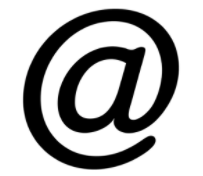



Sebagai calon Business Intelligence Analyst yang mahir, tentunya diharapkan kita dapat membedakan penggunaan karakter “@” ini dalam konteks yang berbeda-beda. Menggunakan dataset **“Artikel_Sosmed.json”**, <font color='red'>**tentukan apakah setiap karakter “@” yang ada dalam dataset termasuk dalam penggunaan untuk jenis akun Email, Twitter, atau Instagram!**</font>

Anda diharuskan untuk merancang regex (boleh lebih dari satu) untuk menjawab soal ini. Gunakan guideline berikut ini untuk membantu Anda. Asumsikan bahwa seluruh penggunaan karakter “@” pada dataset ini hanya termasuk pada jenis akun Email, Twitter, atau Instagram (tidak ada media sosial atau penggunaan lainnya).

<br/>

**Catatan:**

Dataset “Artikel_Sosmed.json” merupakan kumpulan artikel berita yang telah dikumpulkan dengan fitur seperti content, section, articleid, author, tag, dan lain-lain. Untuk kepentingan tugas ini, kolom yang digunakan dari dataset adalah fitur <font color='red'>**"content"**</font> saja.

**** 
<br/>

Jawaban Anda untuk bagian ini diharuskan berbentuk baris-baris yang berisi “[NAMA_AKUN] - [JUMLAH_MUNCUL]” untuk setiap akun yang ditemukan. 

<br/>

Contoh Artikel:

Pada mata kuliah analitika media sosial (kontak: analitika_medsos@cs.ui.ac.id) terdapat beberapa akun sosial media. Diantaranya adalah akun @dota2, akun @naed\_aar, dan akun @abstr$aksi\_lucu. Akun @dota2 merupakan akun twitter dengan followers terbanyak jika dibandingkan dengan kedua akun lainnya. Selain itu, terdapat juga akun email terbaru yang dimiliki Iwe bernama genshin-anniversary@hoyoverse.com.

<br/>

Jawaban dari Artikel tersebut akan berupa

Untuk akun Email:

- analitika_medsos@cs.ui.ac.id - 1
- genshin-anniversary@hoyoverse.com - 1

Untuk akun media sosial:

- @naed_aar - 1
- @dota2 - 2
- @abstr - 1 (terdapat karakter '$' sehingga akun yang valid hanya @abstr saja)


### **Ketentuan Akun Email / Twitter / Instagram**

1. Setiap akun pastinya hanya memiliki satu karakter “@”
2. Setiap akun juga tidak dapat diakhiri dengan tanda “.”
3. Akun Email memiliki karakter “@” yang diapit oleh dua token. Dengan kata lain, suatu akun Email berbentuk [Token1]@[Token2]. 

  a. Setiap token pada suatu akun Email dapat terdiri dari karakter-karakter alphanumeric (A-z, 0-9), tanda “.”, tanda “-”, atau tanda “_”

  b. Khusus untuk Token 2, harus terdapat minimal 1 tanda “.”

  c. Beberapa contoh akun **email** valid: 

  - akun-anmedsos@gmail.com
  - akun\_\_anm@cs.ui\_\_
  - anmedsos.4.life@my-hobbies.uk.id-

  d. Beberapa contoh akun email tidak valid:

  - not$valid\_@cs.ui
  - m4ta\_bat1n@magician\_\_
  - kamisato-ayato-op@genshin.life.

4. Akun media sosial memiliki karakter “@” di awal dan diikuti oleh satu token. Dengan kata lain, suatu akun media sosial berbentuk @[Token].

  a. Token maksimal terdiri dari 15 karakter

  b. Token pada akun media sosial hanya bisa terdiri dari karakter-karakter alphanumeric (A-z, 0-9), tanda “.”, atau tanda “_”

  c. Beberapa contoh akun media sosial valid: 
  - @iwuvu3000
  - @the_king.ar
  - @1panic__

  d. Beberapa contoh akun media sosial tidak valid:
  - @info-retrieve
  - @lulus2021.
  - @fake_soc_med_account

5. Khusus untuk akun Twitter, dapat dipastikan bahwa tidak terdapat karakter “.” pada token


asumsi tambahan
<br>
untuk [token2] email
<br>
Domains can be formed using only use letters and numbers from the ASCII set of characters e.g. (a-z) (A-Z) (0-9). Hyphens are also allowed but must be surrounded by characters, therefore not at the beginning or end of the domain. You're not allowed to use special characters (like '#*%') and spaces cannot be used.
<br>
https://www.20i.com/support/domain-names/domain-name-restrictions

In [ ]:
email_pattern = '([A-z0-9\._\-]+)(@)([A-z0-9]+[\-]{1}[A-z0-9]+|[A-z0-9]+)(\.([A-z0-9]+[\-]{1}[A-z0-9]+|[A-z0-9]+))+'
instagram_pattern = '([^A-z0-9])(@)([A-z0-9\_\.]{1,15})'
twitter_pattern = '([^A-z0-9])(@)([A-z0-9\_]{1,15})'

In [ ]:
import json

file_artikel_sosmed = open(path + 'Artikel_Sosmed.json')
artikel_sosmed = json.load(file_artikel_sosmed)

In [ ]:
def count_findings(the_findings):
    findings = dict()
    for f in the_findings:
        findings[f] = findings.setdefault(f,0) + 1
    return findings

def cetak(nama, nama_count):
    print('\n\nini lah hasil perhitungan '+nama+'\n')
    for n in nama_count:
        print(''.join(n), nama_count[n])

In [ ]:
email_find = []
twitter_find = []
instagram_find = []
for artikel in artikel_sosmed:
    email_find += re.findall(email_pattern, artikel['content'])
    twitter_find += re.findall(twitter_pattern, artikel['content'])
    instagram_find += re.findall(instagram_pattern, artikel['content'])

email_count = count_findings(email_find)
twitter_count = count_findings(twitter_find)
instagram_count = count_findings(instagram_find)

cetak('email', email_count)
cetak('twitter', twitter_count)
cetak('instagram', instagram_count)



ini lah hasil perhitungan email

info@railink.idid 1
infopemilu.LHKPN@kpk.idid 1


ini lah hasil perhitungan twitter

 @rr 1
 @lambe_turah 1
 @txtdaribogor 1
 @listongs 2
 @tirta_hudhi 1
 @ridwankamil 2
 @prakerja 1
 @kontributorjaka 1
 @acmawards 2
 @ito 1
 @firdzaradiany 1
 @ganangsy 1
 @tyonarie2 1
 @MushinAshin3 1
 @FerdinandHaean3 1
 @basukibtp 2
 @yasshh19 1
 @cositadelanoche 1

@Aikaz_F 1
 @Aikaz_F 1
 @commuterline 3
 @prastow 1
 @KPK_RI 1
 @TMCPoldaMetro 2
 @pahlawandigital 1
 @kemenkopukm 1
 @putri_tanjung 1
 @rizqiawal 1
 @syekh 1
 @warung_jurnalis 1
 @BennyHarmanID 2
 @NetflixUK 2
 @WallnerAndi 1
 @jakarta 1
 @Aditt_hr 2
 @adiw9237 2
 @miztabay 2
 @chandra_ds 3
 @sbotv 1
 @_KingPurwa 1
 @boazsolossa 1
 @abangriza 1
 @m3takl_en 1
 @infobekasi 1
 @regureg 1
 @Dwinamasayaa 1
 @kaesangp 1
 @HRimanti 1
 @txtdaripooh 1


ini lah hasil perhitungan instagram

 @rr.irwin 1
 @lambe_turah. 1
 @txtdaribogor 1
 @listongs. 1
 @listongs 1
 @tirta_hudhi 1
 @ridwankamil 2
 @prakerja.go.id.

# C. Aspect-Based Sentiment Analysis

Pada bagian ini, kita akan mengeksplorasi salah satu use case dari Regex pattern, yaitu untuk **Aspect-Based Sentiment Analysis**. Aspect-Based Sentiment Analysis adalah teknik untuk melakukan analisis sentimen untuk beberapa aspek secara sekaligus dari satu dokumen teks.

Contohnya, jika kita memiliki dokumen ulasan sebagai berikut:
> *Kemarin aku sempatkan mampir ke restoran Wanmin untuk makan siang. Hidangannya sangat lezat!  Pelayanannya juga sangat ramah. Harga cukup standar. Sayang saja tempatnya kecil dan ramai.*

Kita bisa mengambil beberapa aspek beserta sentimennya yang dibahas terkait restoran ini:

| Aspek     | Penilaian       | Sentimen |
|-----------|-----------------|----------|
| Hidangan  | Lezat           | Positif  |
| Pelayanan | Ramah           | Positif  |
| Harga     | Standar         | Netral   |
| Tempat    | Kecil dan Ramai | Negatif  |

Dengan adanya penilaian sentimen aspek secara spesifik, pemilik restoran bisa mengambil keputusan yang lebih tepat dalam meningkatkan penilaian terhadap restorannya.

Lalu apakah ini ada kaitannya dengan Regex yang telah kita pelajari? Ekstraksi pasangan aspek-sentimen memang sulit dilakukan jika kita hanya mengandalkan Regex saja. Namun, kita bisa menggabungkannya dengan POS Tagging yang sempat didemokan pada Bagian A.

Pembahasan pada tutorial ini sampai pada ekstraksi pasangan aspek-sentimen dari sebuah dokumen ulasan.

## <span>1. Dataset</span>

Untuk bagian ini, kita akan menggunakan dataset lain. Dataset yang digunakan adalah data ulasan Hotel yang terdaftar di Airy Rooms. Data ulasan ini sudah dianotasi dan memiliki 10 aspek untuk setiap ulasannya dengan variasi nilai (positif, netral, negatif).

Untuk tutorial ini, kita akan mengeksplorasi bagaimana kita bisa mengekstrak pasangan aspek-sentimen dari data teks dengan menggunakan POS Tagging dan Regex.

****
Referensi: Azhar, A. N., Khodra, M. L., & Sutiono, A. P. (2019, July). Multi-label aspect categorization with convolutional neural networks and extreme gradient boosting. In 2019 International Conference on Electrical Engineering and Informatics (ICEEI) (pp. 35-40). IEEE. (https://ieeexplore.ieee.org/abstract/document/8988898/?casa_token=7x-oD85mEeUAAAAA:QiNdLfyhxJFnfR7UN0bUGK3Ur4Tad_gV7eK_ALtOFiMau8DYz7L4rFkLIII4iaJJpfhIk8YxrVV-)

In [ ]:
# Import dataset
df_train = pd.read_csv(path + "hoasa_absa-airy/train_preprocess.csv")
df_train.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


Selanjutnya kita coba petakan kata-kata apa yang banyak dibahas pada dataset ulasan hotel dengan menggunakan Wordcloud.

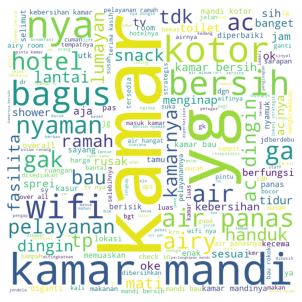

In [ ]:
from wordcloud import WordCloud

stopwords = pd.read_csv(path + 'stopwords.csv', header=None)[0].values

reviews_string = " ".join(df_train['review']).lower()

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(reviews_string)

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## <span>2. POS Tagging</span>

Serupa dengan pada saat klasifikasi, kita akan menggunakan model POS Tagger yang sudah dilatih pada dataset teks Bahasa Indonesia yang dianotasi secara manual. Daftar tag beserta deskripsi POS Tag utamanya mengikuti yang terdapat pada [Penn Treebank POS Tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html). Kemudian, dikembangkan lebih lanjut oleh Dinakaramani et al. (2014). Berikut adalah beberapa contoh tag beserta deskripsinya

| Tag | Deskripsi                     | Contoh                      |
|-----|-------------------------------|-----------------------------|
| CC  | Kata Konjungsi Kalimat Setara | dan, tetapi, atau           |
| IN  | Kata Preposisi                | dalam, dengan, di, ke       |
| JJ  | Kata Sifat (Adjective)        | bersih, indah, panas        |
| NEG | Kata Negasi                   | tidak, belum                |
| NN  | Kata Benda (Noun)             | kamar, meja                 |
| NNP | Proper Noun                   | Laut Jawa, Indonesia, Senin |
| RB  | Kata Keterangan (Adverb)      | sangat, hanya               |
| VB  | Kata Kerja (Verb)             | atur, pergi, tidur          |
| Z   | Tanda Baca (Punctuation)      | ...,?!                      |

****
Referensi: Dinakaramani, A., Rashel, F., Luthfi, A., & Manurung, R. (2014, October). Designing an Indonesian part of speech tagset and manually tagged Indonesian corpus. In 2014 International Conference on Asian Language Processing (IALP) (pp. 66-69). IEEE. (https://ieeexplore.ieee.org/abstract/document/6973519)

In [ ]:
ct = CRFTagger()
ct.set_model_file(path + "all_indo_man_tag_corpus_model.crf.tagger")

def pos_tagging(review):
  tokens = nltk.word_tokenize(review)
  tag = ct.tag_sents([tokens])
  flat_tag = [item for sublist in tag for item in sublist]
  return " ".join([token+"/"+pos_tag for token,pos_tag in flat_tag])

sample_reviews = df_train['review'].to_list()[:5]
for i in sample_reviews:
  print("Dokumen Asli:", i)
  print("POS Tagged  :", pos_tagging(i))
  print("===========")

Dokumen Asli: kebersihan kurang...
POS Tagged  : kebersihan/NN kurang/RB .../Z
Dokumen Asli: sangat mengecewakan... hotel bad image, kebersihan kurang, berisik
POS Tagged  : sangat/RB mengecewakan/VB .../Z hotel/NN bad/FW image/FW ,/Z kebersihan/NN kurang/RB ,/Z berisik/NN
Dokumen Asli: Tempat nyaman bersih tapi tv terlalu tinggi tidak bisa di lihat 
POS Tagged  : Tempat/NN nyaman/NN bersih/JJ tapi/CC tv/NN terlalu/RB tinggi/JJ tidak/NEG bisa/MD di/IN lihat/VB
Dokumen Asli: semuanya bagus sesuai profile,dan harga promo untuk suite nya jg sangat murah..komplain cuma water heater yg kamar saya tidak keluar dan air keluar kecil
POS Tagged  : semuanya/RB bagus/JJ sesuai/JJ profile/FW ,/Z dan/CC harga/NN promo/NN untuk/SC suite/NN nya/NN jg/NN sangat/RB murah..komplain/JJ cuma/RB water/FW heater/FW yg/FW kamar/NN saya/PRP tidak/NEG keluar/VB dan/CC air/NN keluar/VB kecil/JJ
Dokumen Asli: Tempat tidur sangat keras, bantal besar dan keras, air panas tidak berfungsi, AC kurang dingin biasanya 

## <span>3. Chunking dengan Regex</span>

Langkah selanjutnya adalah kita menggunakan Regex untuk melakukan *chunking*. *Chunking* adalah proses ekstraksi suatu frasa, klausa, atau bagian dari teks berdasarkan pola dari POS Tag yang terdapat pada teks tersebut.

Untuk konteks Aspect-Based Sentiment Analysis, kita bisa menggunakan *chunking* untuk mengekstrak pasangan aspek beserta sentimennya. Pada umumnya, aspek memiliki asosiasi tinggi dengan kata benda (NN). Di sisi lain, kata sentimen memiliki asosiasi tinggi dengan kata sifat (JJ). Sehingga, kita bisa mendapatkan pattern utama `[NN] [JJ]`.

Selanjutnya, ada beberapa kata lain juga yang bisa terselip di antara NN dan JJ. Misalnya, `"kamarnya/NN sangat/RB tidak/NEG nyaman/JJ"`. Di antara NN dan JJ bisa juga muncul kata keterangan (RB) dan kata negasi (NEG).


Berdasarkan hipotesis di atas, kita coba gunakan Regex pattern berikut:

```
((?:\w+\/NN\w?\s?)+\s?(?:\w+\/(?:RB\w?|NEG))*\s?(?:\w+\/JJ))
```

Penjelasan:
- `(?:\w+\/NN\w?\s?)`: Match satu atau lebih kata yang memiliki tag kata benda (NN)
- `(?:\w+\/(?:RB\w?|NEG))?`: [Optional] Match satu atau lebih kata yang memiliki tag kata keterangan (RB) maupun kata negasi (NEG)
- `(?:\w+\/JJ))+`: Match satu atau lebih kata yang memiliki tag kata sifat (JJ) 

In [ ]:
pattern = "((?:\w+\/NN\w?\s?)+\s?(?:\w+\/(?:RB\w?|NEG))*\s?(?:\w+\/JJ))+"

In [ ]:
def chunk(tagged):
  return re.findall(pattern, tagged)

In [ ]:
chunks = []

for review in tqdm(df_train['review'].to_list()):
  tagged = pos_tagging(review)
  chunked = chunk(tagged)
  chunks.append(chunked)

# Preview beberapa data
[c for c in chunks if len(c) != 0][:5]

100%|██████████| 2283/2283 [00:01<00:00, 2183.52it/s]


[['Tempat/NN nyaman/NN bersih/JJ', 'tv/NN terlalu/RB tinggi/JJ'],
 ['bantal/NN besar/JJ', 'air/NN panas/JJ'],
 ['pagi/NN baru/JJ'],
 ['Kamar/NNP tidak/NEG sesuai/JJ'],
 ['kamar/NN byk/NN ngengat/NN kecil/JJ']]

## Tugas Tutorial C

Setelah dilakukan *chunking*, langkah selanjutnya Anda diminta untuk mengimplementasikan untuk ekstraksi tiga komponen sebagai tuple dengan **menggunakan Regex**:
- `aspect`: Diambil dari rangkaian kata benda di chunk
- `sentiment`: Diambil dari rangkaian kata sifat di chunk
- `hasNegation` (boolean): Apakah chunk mengandung kata negasi
****

- Contoh input: 
```
Pelayan yg baik dan ramah. tempat sesuai dengan gambar. tempat strategis sehingga memudahkan akses kemanapun. Namun, kualitas wifi perlu diperbaiki, karena jaringan yg sangat lambat.
```
- Contoh chunk:
```
['Pelayan/NN yg/NN baik/JJ',
 'tempat/NN sesuai/JJ',
 'tempat/NN strategis/JJ',
 'jaringan/NN yg/NN sangat/RB lambat/JJ']
```
- Contoh output yang diharapkan:
```
[('Pelayan yg', 'baik', False),
 ('tempat', 'sesuai', False),
 ('tempat', 'strategis', False),
 ('jaringan yg', 'lambat', False)]
```

